# The _Stochastic Simulation Algorithm_
## Introduction
The stochastic simulation algorithm (SSA) is a Monte Carlo method that was developed to study mass action models of well-mixed, reactive chemical mixtures. Here, three versions of the SSA-- _direct_, _first-reaction_, and _first-family_ methods are implemented as generator members of a Python class, and their abilities and properties are explored from the lenses of statistics and compute complexity.

As previously mentioned, the SSA was at some point devised in the scientific literature as an avenue to simulate complex reactive chemical mixtures. In saying "simulate a reactive chemical mixture", we mean that the SSA accepts a set of relevant parameters (arrays of initial species concentrations, among other things) and returns each of these arrays with time-ordered changes that are statistically "accurate". We will call this set of arrays a _trajectory_ of the reactive chemical mixture. One of the most interesting results garnered from use of the SSA is that the statistics of a large group, or _ensemble_, of trajectories carries in it's moments the exact solution of the mixture's mass-action kinetics.
## Python implementation
The [introduction](##Introduction) discussed the history, utility, and high-level nature of the SSA. This section details the actual _design_ and _implementation_ of the SSA as Python source code. Rather than lead with prose, please just consider the implementation:

At the top level, a convenient Python implementation of the SSA would be an indefinite generator of single trajectories, which
 * yields trajectories in a for-loop that are passed directly to `matplotlib.pyplot`,
 * and can exit safely with the `break` keyword.
Here is such an implementation, specifically a Python class whose members are an initializer, and the three SSA versions dicussed in [Gillespie's review](http://cctbio.ece.umn.edu/wiki/images/7/78/Gillespie-Daniel-T_Stochastic_Simulation_of_Chemical_Kinetics.pdf):

In [49]:
from math import log
from random import random, seed
from warnings import warn


class SSA:
    """Container for Stochastic Simulation Algorithms"""

    def __init__(self, a=None, version=None):
        """Initializer for SSA methods"""
        if a is not None or version is not None:
            seed(a=a, version=(version or 2))

    def direct(self, model):
        """Indefinite generator of direct-method trajectories"""
        while True:
            while not model.exit():
                
                # init step: reaction probabilties and partition func
                weights = list((k, v(model)) for k,v in model.propen)
                partition = sum(t[1] for t in weights)
                print(partition, weights)
                print(partition, weights)
                
                # monte carlo step 1: next reaction time
                model["time"].append(
                    log(1.0 / random()) / partition
                )
                
                # monte carlo step 2: next reaction
                next_reaction = partition * random()
                curr_reaction = 0.0
                while curr_reaction < next_reaction:
                    curr_reaction += weights.pop()[1]
                        
                reaction_stoich = model.stoich[weights.pop()[0]]

                # update reaction species
                for species, delta in reaction_stoich.items():
                    model[species] += delta

            yield model.trajectory
            model.reset()

    def first_reaction(self, model):
        """Indefinite generator of 1st-reaction trajectories"""
        while True:
            while not model.exit():

                # monte carlo step: generate reaction times
                times = list(
                    (k,  log(1.0 / random()) / v(model))
                    for k,v in model.propen
                ).sort(key=lambda t: t[1])

                # update next reaction time
                model["time"].append(times[0][1])

                # update reaction species
                reaction_stoich = model.stoich[times[0][0]]
                for species, delta in reaction_stoich:
                    model[species] += delta

            yield model.trajectory
            model.reset()
            

In [37]:
class Model(dict):
    """An abstract model for the SSA"""
    
    def __init__(
        self,
        initial_conditions: dict,
        propensities: dict,
        stoichiometries: dict
    ):
        self.propen = sorted(
            propensities.items(), reverse=True
        )
        self.stoich = list(stoichiometry.items())
        super().__init__(**initial_conditions)
        
    def exit(self, *args, **kwargs):
        pass
        
    def reset(self, *args, **kwargs):
        pass
    

In [38]:
# initial species counts and sojourn times
initital_conditions = {
    "s": [299],
    "i": [1],
    "r": [0],
    "time": [0.0],
}


# propensity functions
propensities = {
    0: lambda d: 0.5 * d["s"][-1] * d["i"][-1] / 300,
    1: lambda d: 2.0 * d["i"][-1],
}


# change in species for each propensity
stoichiometry = {
    0: {"s": -1, "i": 1, "r": 0},
    1: {"s": 0, "i": -1, "r": 1},
}

In [39]:
class Epidemic(Model):
    """Simple SIR epidemic"""
    
    def exit(self):
        if self["s"] == 0 or self["i"] == 0:
            return True
        else:
            return False
            
    def reset(self):
        for key in self.keys():
            del self[key][1:]
            

In [40]:
sir_epidemic = Epidemic(
    initital_conditions, propensities, stoichiometry
)

2.4983333333333335 [(1, 2.0), (0, 0.49833333333333335)]
2.4983333333333335 [(1, 0.800533689126084), (0, 0.19946631087391595)]


IndexError: pop from empty list

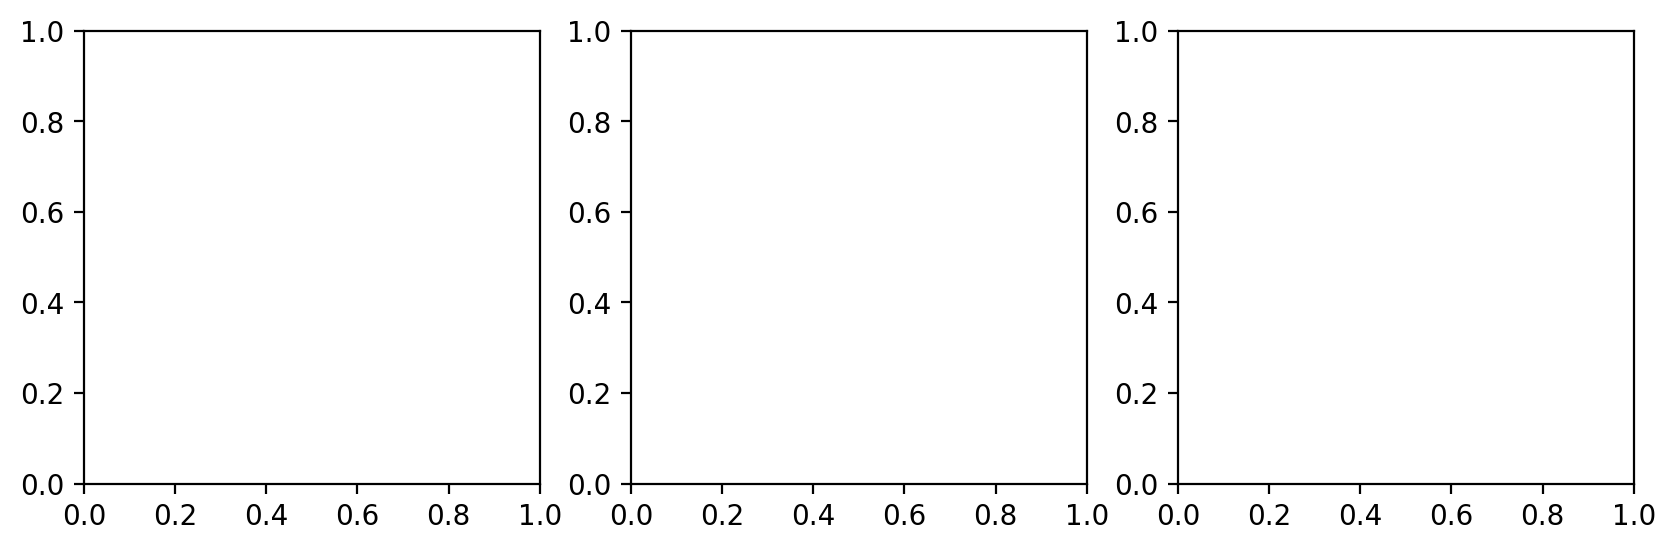

In [50]:
from matplotlib import pyplot, rcParams


# make figure 10" x 3", 200 dots per inch
rcParams["figure.figsize"] = 10, 3
rcParams["figure.dpi"] = 200


# instantiate figure and axes
figure, axes = pyplot.subplots(1, 3)


# append trajectories to plot
simulator = SSA()
trajectories = 0
for trajectory in simulator.direct(sir_epidemic):
    
    # exit condition
    if trajectories <= 40:
        break
        
    # do plotting
    for k,v in trajectory.items():
        if k == "time":
            continue
        axes.plot(trajectory["time"], v)
        